In [1]:
# unzip dataset_letras.zip
!unzip dataset_letras2.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset_letras2/Q/Q_106.png  
 extracting: dataset_letras2/Q/Q_107.png  
 extracting: dataset_letras2/Q/Q_108.png  
 extracting: dataset_letras2/Q/Q_109.png  
 extracting: dataset_letras2/Q/Q_11.png  
 extracting: dataset_letras2/Q/Q_110.png  
 extracting: dataset_letras2/Q/Q_111.png  
 extracting: dataset_letras2/Q/Q_112.png  
 extracting: dataset_letras2/Q/Q_113.png  
 extracting: dataset_letras2/Q/Q_114.png  
 extracting: dataset_letras2/Q/Q_115.png  
 extracting: dataset_letras2/Q/Q_116.png  
 extracting: dataset_letras2/Q/Q_117.png  
 extracting: dataset_letras2/Q/Q_118.png  
 extracting: dataset_letras2/Q/Q_119.png  
 extracting: dataset_letras2/Q/Q_12.png  
 extracting: dataset_letras2/Q/Q_120.png  
 extracting: dataset_letras2/Q/Q_121.png  
 extracting: dataset_letras2/Q/Q_122.png  
 extracting: dataset_letras2/Q/Q_123.png  
 extracting: dataset_letras2/Q/Q_124.png  
 extracting: dataset_letras2/Q/Q_125.png  
 extr

In [3]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [4]:
import wandb

## Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

## Inicializa WandB
wandb.init(project="repte1_psiv", entity="andreu-mir")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andreu-mir. Use `wandb login --relogin` to force relogin


# 1. Arquitectura model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Definir las capas convolucionales y de agrupamiento
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Capa convolucional 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 1

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Capa convolucional 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 2

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Capa convolucional 3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 3

        # Ajustar la capa fully connected para 26 clases
        self.fc1 = nn.Linear(128 * 8 * 5, 128)  # Capa densa
        self.dropout = nn.Dropout(0.5)  # Dropout para regularización
        self.fc2 = nn.Linear(128, 26)  # Capa de salida ajustada a 26 clases

    def forward(self, x):
        # Definir el paso hacia adelante
        x = self.pool1(F.relu(self.conv1(x)))  # Capa 1
        x = self.pool2(F.relu(self.conv2(x)))  # Capa 2
        x = self.pool3(F.relu(self.conv3(x)))  # Capa 3

        x = x.view(-1, 128 * 8 * 5)  # Aplanar la salida para la capa densa
        x = F.relu(self.fc1(x))  # Capa densa
        x = self.dropout(x)  # Aplicar dropout
        x = self.fc2(x)  # Capa de salida

        return x

# Crear una instancia del modelo
model = CNNModel()


# 2. Dataset

In [12]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar WandB
wandb.init(project="letra_recognition_cnn")

# Definición de parámetros
batch_size = 32
img_height, img_width = 64, 40  # Tamaño de las imágenes

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Redimensionar las imágenes
    transforms.Grayscale(num_output_channels=1),  # Asegurarse de que la imagen sea en escala de grises
    transforms.ToTensor(),  # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,)),  # Normalizar las imágenes (grayscale)
])

# Cargar el dataset
base_dir = 'dataset_letras2'
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Número de pliegues para la validación cruzada
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Verificación
print(f"Total dataset size: {len(dataset)}")

wandb: Currently logged in as: andreu-mir (xisca). Use `wandb login --relogin` to force relogin


Total dataset size: 13000


# 3. Train Model

In [13]:
import torch.nn as nn
import torch.optim as optim

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# see shape of dataset_letras\0\0_0.png

print(dataset[0][0].shape)

torch.Size([1, 64, 40])


Fold 1/5
Epoch [1/20], Loss: 0.2569, Accuracy: 0.9226
Epoch [2/20], Loss: 0.1661, Accuracy: 0.9484
Epoch [3/20], Loss: 0.1381, Accuracy: 0.9565
Epoch [4/20], Loss: 0.1186, Accuracy: 0.9619
Epoch [5/20], Loss: 0.0898, Accuracy: 0.9699
Epoch [6/20], Loss: 0.0806, Accuracy: 0.9738
Epoch [7/20], Loss: 0.0750, Accuracy: 0.9752
Epoch [8/20], Loss: 0.0647, Accuracy: 0.9782
Epoch [9/20], Loss: 0.0657, Accuracy: 0.9780
Epoch [10/20], Loss: 0.0539, Accuracy: 0.9814
Epoch [11/20], Loss: 0.0546, Accuracy: 0.9812
Epoch [12/20], Loss: 0.0489, Accuracy: 0.9840
Epoch [13/20], Loss: 0.0596, Accuracy: 0.9824
Epoch [14/20], Loss: 0.0445, Accuracy: 0.9843
Epoch [15/20], Loss: 0.0416, Accuracy: 0.9862
Epoch [16/20], Loss: 0.0339, Accuracy: 0.9893
Epoch [17/20], Loss: 0.0402, Accuracy: 0.9865
Epoch [18/20], Loss: 0.0362, Accuracy: 0.9882
Epoch [19/20], Loss: 0.0446, Accuracy: 0.9862
Epoch [20/20], Loss: 0.0417, Accuracy: 0.9875
Validation Loss: 0.0378, Validation Accuracy: 0.9881
Validation Precision: 0.988

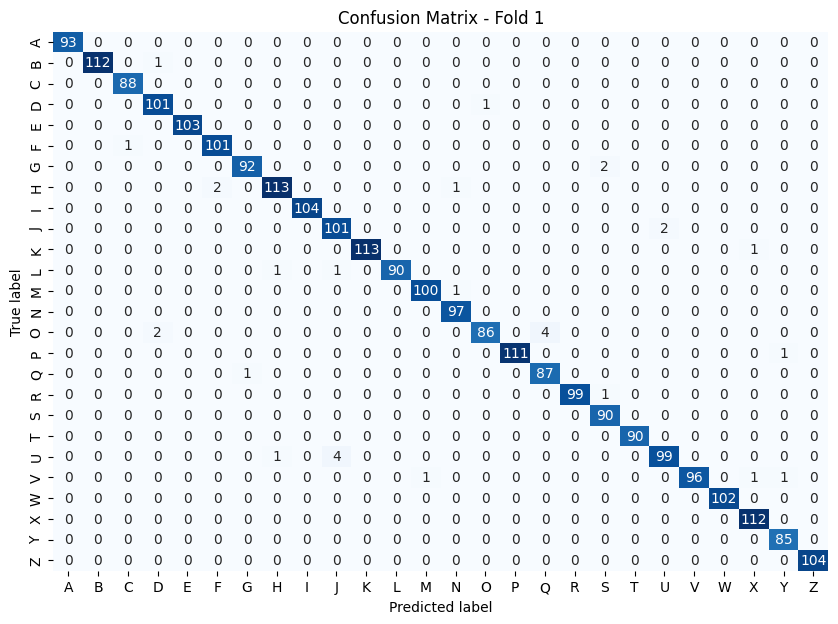

Fold 2/5
Epoch [1/20], Loss: 0.0446, Accuracy: 0.9862
Epoch [2/20], Loss: 0.0464, Accuracy: 0.9838
Epoch [3/20], Loss: 0.0315, Accuracy: 0.9890
Epoch [4/20], Loss: 0.0310, Accuracy: 0.9902
Epoch [5/20], Loss: 0.0330, Accuracy: 0.9893
Epoch [6/20], Loss: 0.0246, Accuracy: 0.9916
Epoch [7/20], Loss: 0.0303, Accuracy: 0.9899
Epoch [8/20], Loss: 0.0312, Accuracy: 0.9898
Epoch [9/20], Loss: 0.0257, Accuracy: 0.9928
Epoch [10/20], Loss: 0.0282, Accuracy: 0.9902
Epoch [11/20], Loss: 0.0289, Accuracy: 0.9907
Epoch [12/20], Loss: 0.0272, Accuracy: 0.9915
Epoch [13/20], Loss: 0.0234, Accuracy: 0.9919
Epoch [14/20], Loss: 0.0306, Accuracy: 0.9912
Epoch [15/20], Loss: 0.0196, Accuracy: 0.9938
Epoch [16/20], Loss: 0.0216, Accuracy: 0.9926
Epoch [17/20], Loss: 0.0179, Accuracy: 0.9945
Epoch [18/20], Loss: 0.0182, Accuracy: 0.9938
Epoch [19/20], Loss: 0.0154, Accuracy: 0.9951
Epoch [20/20], Loss: 0.0214, Accuracy: 0.9938
Validation Loss: 0.0161, Validation Accuracy: 0.9954
Validation Precision: 0.995

<Figure size 640x480 with 0 Axes>

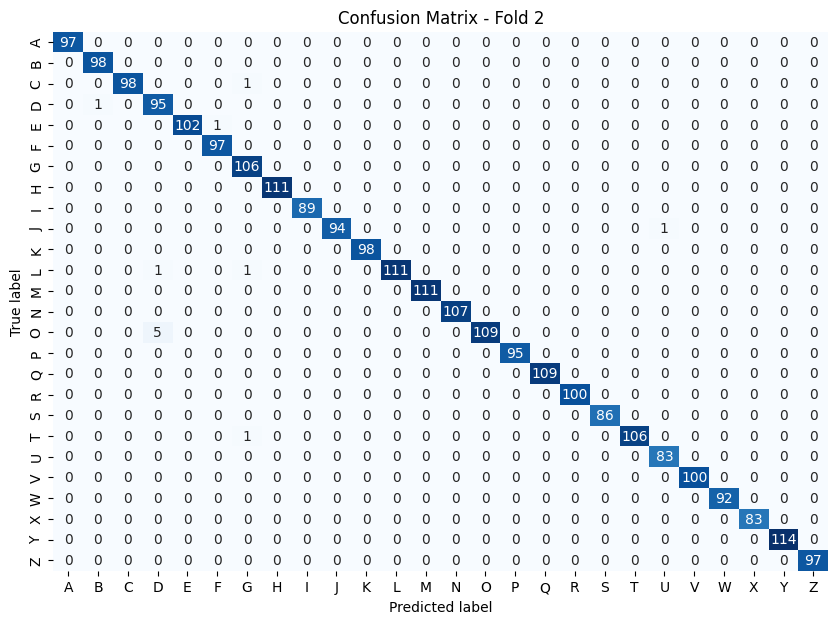

Fold 3/5
Epoch [1/20], Loss: 0.0420, Accuracy: 0.9868
Epoch [2/20], Loss: 0.0311, Accuracy: 0.9899
Epoch [3/20], Loss: 0.0280, Accuracy: 0.9912
Epoch [4/20], Loss: 0.0202, Accuracy: 0.9938
Epoch [5/20], Loss: 0.0183, Accuracy: 0.9943
Epoch [6/20], Loss: 0.0184, Accuracy: 0.9938
Epoch [7/20], Loss: 0.0156, Accuracy: 0.9955
Epoch [8/20], Loss: 0.0198, Accuracy: 0.9932
Epoch [9/20], Loss: 0.0170, Accuracy: 0.9937
Epoch [10/20], Loss: 0.0252, Accuracy: 0.9928
Epoch [11/20], Loss: 0.0229, Accuracy: 0.9937
Epoch [12/20], Loss: 0.0240, Accuracy: 0.9930
Epoch [13/20], Loss: 0.0203, Accuracy: 0.9935
Epoch [14/20], Loss: 0.0138, Accuracy: 0.9962
Epoch [15/20], Loss: 0.0126, Accuracy: 0.9958
Epoch [16/20], Loss: 0.0140, Accuracy: 0.9950
Epoch [17/20], Loss: 0.0097, Accuracy: 0.9972
Epoch [18/20], Loss: 0.0216, Accuracy: 0.9933
Epoch [19/20], Loss: 0.0210, Accuracy: 0.9937
Epoch [20/20], Loss: 0.0201, Accuracy: 0.9946
Validation Loss: 0.0119, Validation Accuracy: 0.9962
Validation Precision: 0.996

<Figure size 640x480 with 0 Axes>

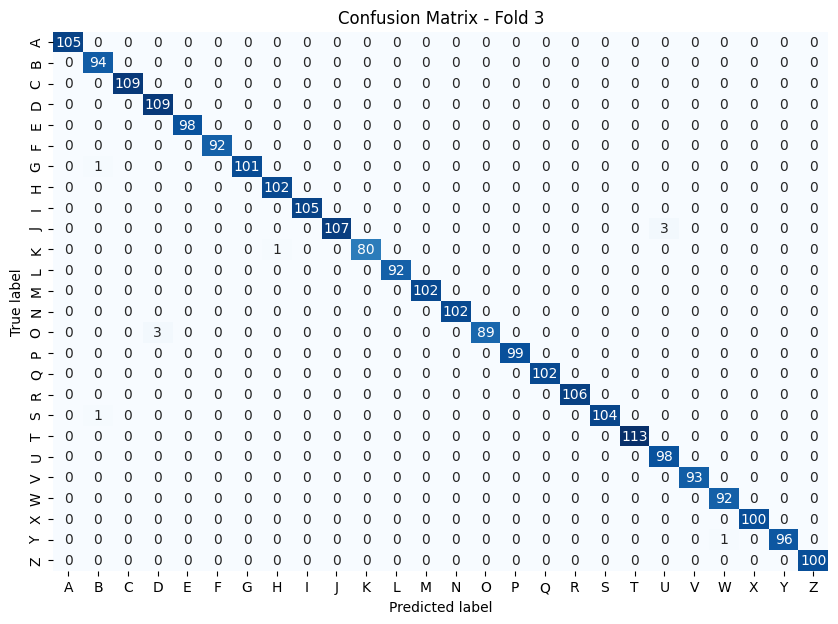

Fold 4/5
Epoch [1/20], Loss: 0.0243, Accuracy: 0.9928
Epoch [2/20], Loss: 0.0168, Accuracy: 0.9943
Epoch [3/20], Loss: 0.0138, Accuracy: 0.9955
Epoch [4/20], Loss: 0.0189, Accuracy: 0.9947
Epoch [5/20], Loss: 0.0180, Accuracy: 0.9946
Epoch [6/20], Loss: 0.0240, Accuracy: 0.9925
Epoch [7/20], Loss: 0.0197, Accuracy: 0.9934
Epoch [8/20], Loss: 0.0155, Accuracy: 0.9958
Epoch [9/20], Loss: 0.0127, Accuracy: 0.9959
Epoch [10/20], Loss: 0.0126, Accuracy: 0.9962
Epoch [11/20], Loss: 0.0096, Accuracy: 0.9971
Epoch [12/20], Loss: 0.0150, Accuracy: 0.9956
Epoch [13/20], Loss: 0.0193, Accuracy: 0.9940
Epoch [14/20], Loss: 0.0303, Accuracy: 0.9918
Epoch [15/20], Loss: 0.0154, Accuracy: 0.9951
Epoch [16/20], Loss: 0.0152, Accuracy: 0.9957
Epoch [17/20], Loss: 0.0154, Accuracy: 0.9952
Epoch [18/20], Loss: 0.0106, Accuracy: 0.9968
Epoch [19/20], Loss: 0.0159, Accuracy: 0.9956
Epoch [20/20], Loss: 0.0132, Accuracy: 0.9967
Validation Loss: 0.0004, Validation Accuracy: 1.0000
Validation Precision: 1.000

<Figure size 640x480 with 0 Axes>

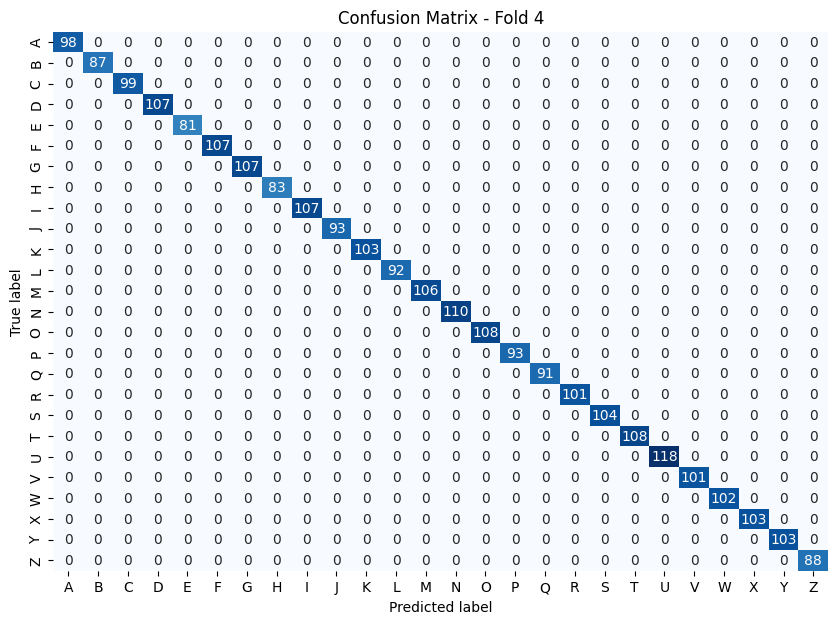

Fold 5/5
Epoch [1/20], Loss: 0.0137, Accuracy: 0.9964
Epoch [2/20], Loss: 0.0219, Accuracy: 0.9944
Epoch [3/20], Loss: 0.0141, Accuracy: 0.9958
Epoch [4/20], Loss: 0.0127, Accuracy: 0.9960
Epoch [5/20], Loss: 0.0114, Accuracy: 0.9964
Epoch [6/20], Loss: 0.0096, Accuracy: 0.9973
Epoch [7/20], Loss: 0.0097, Accuracy: 0.9977
Epoch [8/20], Loss: 0.0241, Accuracy: 0.9943
Epoch [9/20], Loss: 0.0187, Accuracy: 0.9945
Epoch [10/20], Loss: 0.0124, Accuracy: 0.9974
Epoch [11/20], Loss: 0.0106, Accuracy: 0.9970
Epoch [12/20], Loss: 0.0066, Accuracy: 0.9974
Epoch [13/20], Loss: 0.0090, Accuracy: 0.9970
Epoch [14/20], Loss: 0.0124, Accuracy: 0.9963
Epoch [15/20], Loss: 0.0181, Accuracy: 0.9952
Epoch [16/20], Loss: 0.0105, Accuracy: 0.9968
Epoch [17/20], Loss: 0.0122, Accuracy: 0.9962
Epoch [18/20], Loss: 0.0153, Accuracy: 0.9951
Epoch [19/20], Loss: 0.0148, Accuracy: 0.9971
Epoch [20/20], Loss: 0.0220, Accuracy: 0.9935
Validation Loss: 0.0030, Validation Accuracy: 0.9996
Validation Precision: 0.999

<Figure size 640x480 with 0 Axes>

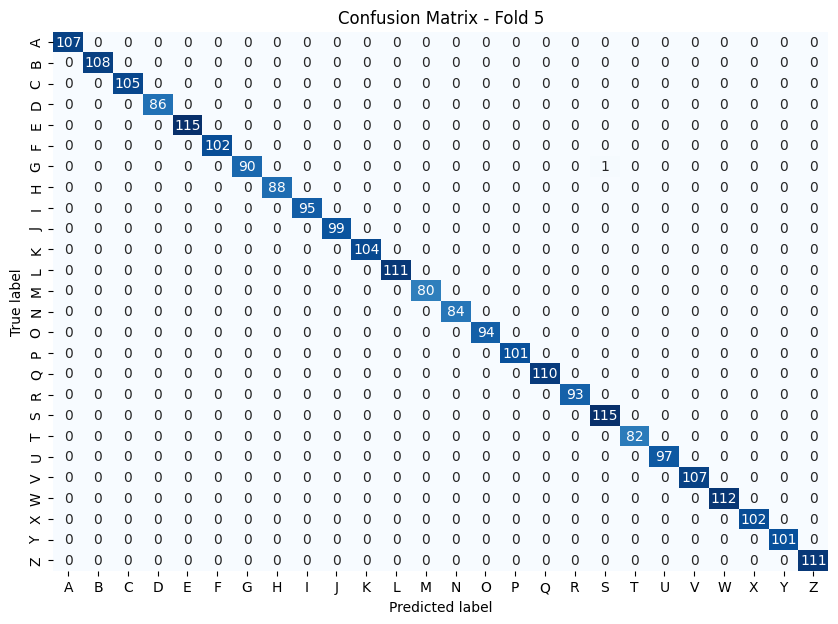

<Figure size 640x480 with 0 Axes>

In [15]:
# Loop a través de los pliegues
for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
    print(f'Fold {fold + 1}/{num_folds}')

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    # Crear DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Mover el modelo a la GPU
    model.to('cuda')

    train_losses = []
    train_accuracies = []

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to('cuda')  # Usa 'cuda' si tienes GPU
            labels = labels.to('cuda')  # Usa 'cuda' si tienes GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcula y registra la pérdida y la precisión
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_accuracy,
        })

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    # Calcula y muestra la pérdida y precisión de validación
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct / val_total

    # Calcular métricas adicionales
    precision = precision_score(val_labels, val_predictions, average='weighted')
    recall = recall_score(val_labels, val_predictions, average='weighted')
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    cm = confusion_matrix(val_labels, val_predictions)

    # Log métricas de validación a WandB
    wandb.log({
        "fold": fold + 1,
        "val_loss": val_epoch_loss,
        "val_accuracy": val_epoch_accuracy,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
    })

    # Imprimir métricas
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Guardar la figura
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.show()
    plt.clf()  # Limpiar la figura para la próxima iteración




In [16]:
# Finaliza la sesión de WandB
wandb.finish()

accuracy,▁▃▆▆▇▇▇▇▇▇▇████▇▇███████████████████████
epoch,▁▁▂▃▄▅▅▆▇▇▂▃▃▄▄▆▆▁▁▄▅▆▆▆▇█▁▂▂▃▅▆▇▁▂▅▅▆▇█
fold,▁▃▅▆█
loss,█▅▅▅▄▃▃▂▃▂▃▃▂▂▂▂▂▂▁▂▁▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁
val_accuracy,▁▅▆██
val_f1,▁▅▆██
val_loss,█▄▃▁▁
val_precision,▁▅▆██
val_recall,▁▅▆██
accuracy,0.99346
epoch,20


In [18]:
model_save_path = f'model_letter_classifier_cnn.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to model_letter_classifier_cnn.pth
